In [3]:
from pathlib import Path
import numpy as np
import pandas as pd

# Configurar rutas relativas al directorio del proyecto
PROJECT_ROOT = Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()
DATA_DIR = PROJECT_ROOT / "data"

# Cargar metadata base
meta = pd.read_csv(DATA_DIR / "master_metadata_initial.csv")
print("Metadata:", meta.shape)

# Cargar features
features = np.load(DATA_DIR / "image_features_resnet50.npy")
index_df = pd.read_csv(DATA_DIR / "image_features_index.csv")

print("Features:", features.shape)
index_df.head()

Metadata: (4491, 4)
Features: (300, 2048)


,image_id,feature_row
0,runway_fashion_runway_images_refined_86743_jpg...,0
1,runway_fashion_runway_images_refined_22220_jpg...,1
2,runway_fashion_runway_images_refined_86966_jpg...,2
3,runway_fashion_runway_images_refined_22164_jpg...,3
4,runway_fashion_runway_images_refined_8969_jpg....,4


In [4]:
# Unir metadata con índice de features por image_id
merged = meta.merge(index_df, on="image_id", how="inner")

print("Merged:", merged.shape)
merged.head()


Merged: (300, 5)


Merged: (300, 5)


,image_id,source,original_dataset,image_path,feature_row
0,runway_fashion_runway_images_refined_15305_jpg...,runway,fashion_runway_images_refined,data/runway/fashion_runway_images_refined/vali...,162
1,runway_fashion_runway_images_refined_8532_jpg....,runway,fashion_runway_images_refined,data/runway/fashion_runway_images_refined/vali...,295
2,runway_fashion_runway_images_refined_15520_jpg...,runway,fashion_runway_images_refined,data/runway/fashion_runway_images_refined/vali...,57
3,runway_fashion_runway_images_refined_16142_jpg...,runway,fashion_runway_images_refined,data/runway/fashion_runway_images_refined/vali...,217
4,runway_fashion_runway_images_refined_86972_jpg...,runway,fashion_runway_images_refined,data/runway/fashion_runway_images_refined/vali...,261


# sanity check!

In [12]:
!pip install scikit-learn


  Using cached scikit_learn-1.7.2-cp313-cp313-macosx_10_13_x86_64.whl.metadata (11 kB)
  Using cached scipy-1.16.3-cp313-cp313-macosx_14_0_x86_64.whl.metadata (62 kB)
  Using cached scipy-1.16.3-cp313-cp313-macosx_14_0_x86_64.whl.metadata (62 kB)
  Using cached joblib-1.5.2-py3-none-any.whl.metadata (5.6 kB)
  Using cached joblib-1.5.2-py3-none-any.whl.metadata (5.6 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
Using cached scikit_learn-1.7.2-cp313-cp313-macosx_10_13_x86_64.whl (9.2 MB)
Using cached joblib-1.5.2-py3-none-any.whl (308 kB)
Using cached scikit_learn-1.7.2-cp313-cp313-macosx_10_13_x86_64.whl (9.2 MB)
Using cached joblib-1.5.2-py3-none-any.whl (308 kB)
Using cached scipy-1.16.3-cp313-cp313-macosx_14_0_x86_64.whl (23.5 MB)
Using cached scipy-1.16.3-cp313-cp313-macosx_14_0_x86_64.whl (23.5 MB)
Using cached threadpoolctl-3.6.0-py3-none-any.whl (18 kB)
Using cached threadpoolctl-3.6.

In [20]:
# Revisar la distribución de clases
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

print("Distribución de clases:")
class_counts = pd.Series(y).value_counts()
print(class_counts)

print(f"\nClases con solo 1 muestra: {sum(class_counts == 1)}")
print(f"Clases con menos de 2 muestras: {sum(class_counts < 2)}")

# Filtrar clases que tienen al menos 2 muestras para poder usar stratify
valid_classes = class_counts[class_counts >= 2].index
print(f"\nClases válidas (>=2 muestras): {len(valid_classes)} de {len(class_counts)}")

# Crear máscara para mantener solo las muestras de clases válidas
mask = pd.Series(y).isin(valid_classes)
X_filtered = X[mask]
y_filtered = y[mask]

print(f"\nDatos filtrados: {X_filtered.shape[0]} muestras de {X.shape[0]} originales")

# Aplicar LabelEncoder a los datos filtrados
le = LabelEncoder()
y_enc = le.fit_transform(y_filtered)

# Ahora dividir con stratify
X_train, X_test, y_train, y_test = train_test_split(
    X_filtered, y_enc, test_size=0.2, random_state=42, stratify=y_enc
)

print(f"Shapes finales - Train: {X_train.shape}, Test: {X_test.shape}")
print(f"Clases en el encoder: {le.classes_}")

Distribución de clases:
top+bottom    36
outerwear     29
dress         29
bottoms        7
top            1
Name: count, dtype: int64

Clases con solo 1 muestra: 1
Clases con menos de 2 muestras: 1

Clases válidas (>=2 muestras): 4 de 5

Datos filtrados: 101 muestras de 102 originales
Shapes finales - Train: (80, 2048), Test: (21, 2048)
Clases en el encoder: ['bottoms' 'dress' 'outerwear' 'top+bottom']


In [21]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(
    max_iter=1000,
    multi_class="multinomial",
    n_jobs=-1
)

clf.fit(X_train, y_train)


/Users/fernandavasquez/runway-trend-intelligence/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'multinomial'


In [22]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=le.classes_))


              precision    recall  f1-score   support

     bottoms       0.00      0.00      0.00         1
       dress       0.67      0.67      0.67         6
   outerwear       0.62      0.83      0.71         6
  top+bottom       0.71      0.62      0.67         8

    accuracy                           0.67        21
   macro avg       0.50      0.53      0.51        21
weighted avg       0.64      0.67      0.65        21



/Users/fernandavasquez/runway-trend-intelligence/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/fernandavasquez/runway-trend-intelligence/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/fernandavasquez/runway-trend-intelligence/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to contr

In [23]:
# merged_df: el DataFrame que ya tenías con image_id + feature_row + source + image_path
merged_df = meta.merge(index_df, on="image_id", how="inner")

# X_all = todos los embeddings de las imágenes para las que tenemos features
X_all = features[merged_df["feature_row"].values]

X_all.shape


(300, 2048)

In [24]:
y_all_pred = clf.predict(X_all)
pred_labels = le.inverse_transform(y_all_pred)

merged_df["pred_category"] = pred_labels
merged_df[["image_id", "source", "image_path", "pred_category"]].head()


,image_id,source,image_path,pred_category
0,runway_fashion_runway_images_refined_15305_jpg...,runway,data/runway/fashion_runway_images_refined/vali...,top+bottom
1,runway_fashion_runway_images_refined_8532_jpg....,runway,data/runway/fashion_runway_images_refined/vali...,outerwear
2,runway_fashion_runway_images_refined_15520_jpg...,runway,data/runway/fashion_runway_images_refined/vali...,dress
3,runway_fashion_runway_images_refined_16142_jpg...,runway,data/runway/fashion_runway_images_refined/vali...,dress
4,runway_fashion_runway_images_refined_86972_jpg...,runway,data/runway/fashion_runway_images_refined/vali...,top+bottom


In [25]:
OUTPUT_CSV = DATA_DIR / "master_metadata_with_category.csv"
merged_df.to_csv(OUTPUT_CSV, index=False)
OUTPUT_CSV


PosixPath('/Users/fernandavasquez/runway-trend-intelligence/data/master_metadata_with_category.csv')

# checks

In [26]:
merged_df["pred_category"].value_counts()


pred_category
dress         157
outerwear      69
top+bottom     68
bottoms         6
Name: count, dtype: int64

In [27]:
merged_df.groupby("source")["pred_category"].value_counts(normalize=True)


source  pred_category
runway  dress            0.649746
        outerwear        0.187817
        top+bottom       0.162437
street  top+bottom       0.349515
        outerwear        0.310680
        dress            0.281553
        bottoms          0.058252
Name: proportion, dtype: float64

## Interpretación de los Resultados

Los números muestran las proporciones de cada categoría predicha para las diferentes fuentes:

### **Runway Fashion**:
- **dress: 64.97%** - Los vestidos dominan claramente la pasarela
- **outerwear: 18.78%** - Abrigos y chaquetas son el segundo más común
- **top+bottom: 16.24%** - Conjuntos de arriba+abajo son menos comunes

###  **Streetwear**:
- **top+bottom: 34.95%** - Los conjuntos separados son más populares
- **outerwear: 31.07%** - Prendas de abrigo muy comunes (similar a runway)
- **dress: 28.16%** - Vestidos menos frecuentes que en runway
- **bottoms: 5.83%** - Pantalones/faldas solos son raros

### **Key insights**:
1. **Pasarela prefiere vestidos** - 65% vs 28% en calle
2. **Calle prefiere versatilidad** - más conjuntos separados (35% vs 16%)
3. **Outerwear es universal** - similar en ambos (18-31%)
4. **Bottoms solos son raros** - solo 6% en calle, puede ser un error del modelo 

In [31]:
!pip install seaborn

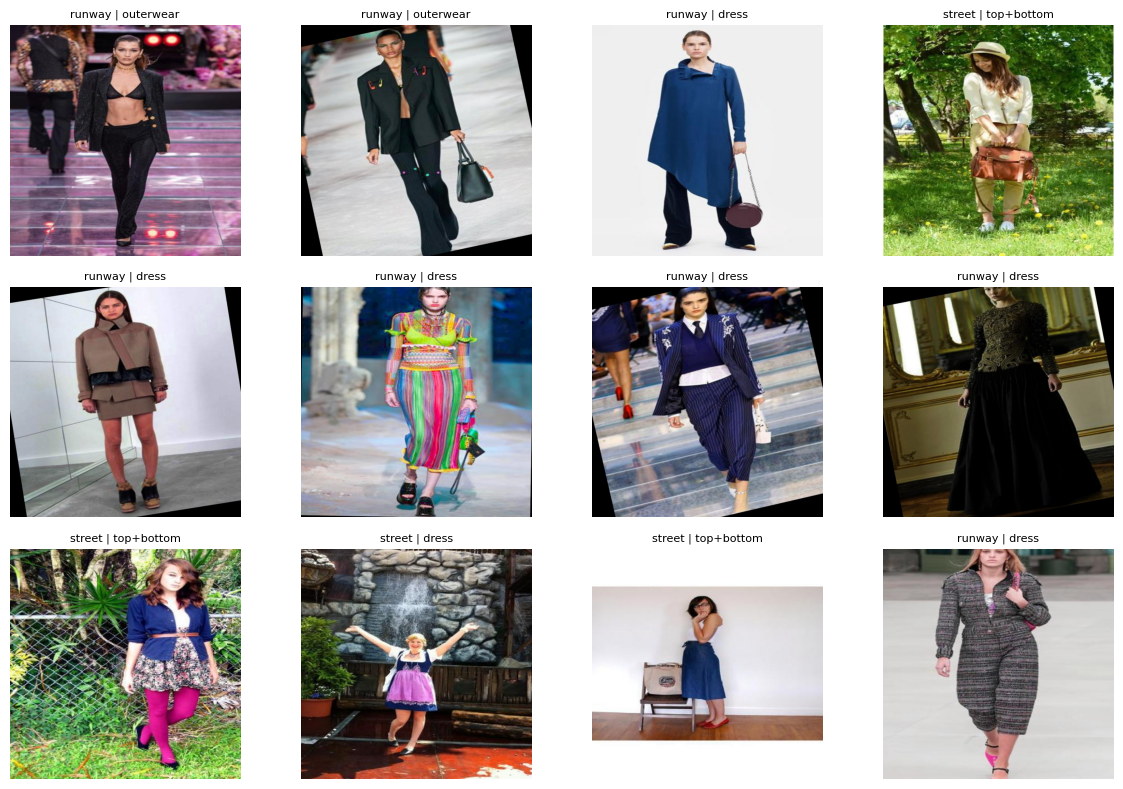

In [32]:
sample = merged_df.sample(12, random_state=1)

from PIL import Image
import matplotlib.pyplot as plt
from pathlib import Path

plt.figure(figsize=(12, 8))
for i, (_, row) in enumerate(sample.iterrows(), start=1):
    img = Image.open(Path(PROJECT_ROOT, row["image_path"])).convert("RGB")
    plt.subplot(3, 4, i)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"{row['source']} | {row['pred_category']}", fontsize=8)
plt.tight_layout()
plt.show()


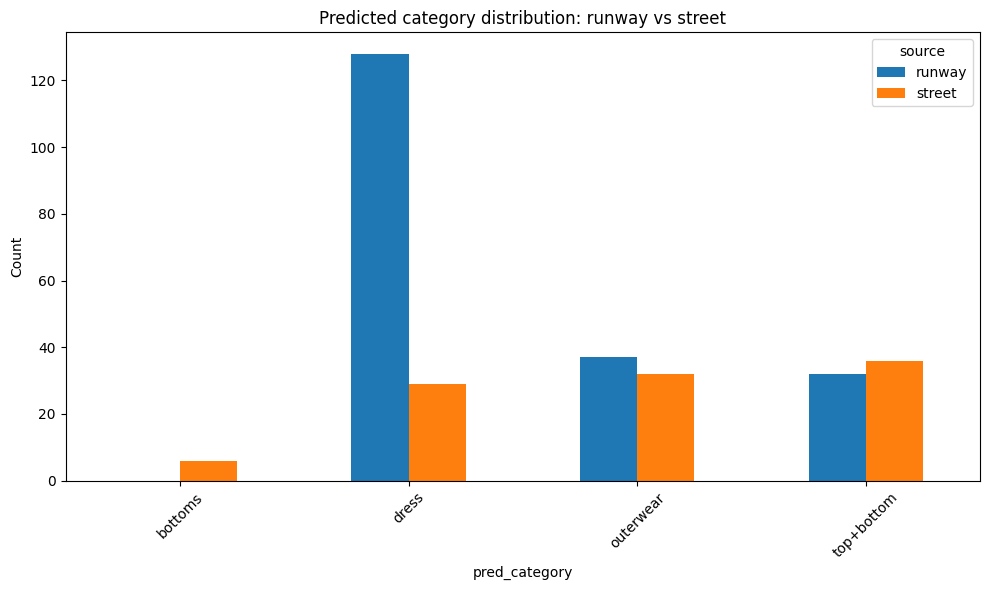

In [33]:
import matplotlib.pyplot as plt

cat_counts = merged_df.groupby("source")["pred_category"].value_counts().unstack().fillna(0)

cat_counts.T.plot(kind="bar", figsize=(10,6))
plt.title("Predicted category distribution: runway vs street")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
